# HANK-SAM

This notebook shows how to **solve a Heterogenous Agent New Keynessian (HANK) model with a search-and-match (SAM) labor market** using the ``GEModelTools`` package.

In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import numpy as np
import scipy.optimize as optimize
from types import SimpleNamespace

import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

from HANKSAMModel import HANKSAMModelClass
from HANKSAMModel import RANKSAMModelClass

In [2]:
def create_fig(figsize=(6,6/1.5)):
    
    fig = plt.figure(figsize=figsize,dpi=100)
    ax = fig.add_subplot(1,1,1)

    return fig,ax

def format_fig(fig,ax,ylabel='',T_max=48,legend=True):

    if legend: ax.legend(frameon=True)
    ax.set_xlabel('months')
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(T_max+1)[::12])
    ax.set_xlim([0,T_max]);
    
    fig.tight_layout()

## Steady state

In [3]:
model = HANKSAMModelClass(name='baseline')

In [4]:
par = model.par
ss = model.ss
path = model.path

ss.u_bar = 6.0

In [5]:
model.find_ss(do_print=True)

par.A = 0.3680
par.kappa = 1.8883
ss.w = 0.7500
ss.delta = 0.0200
ss.lambda_u_s = 0.3000
ss.lambda_v = 0.5000
ss.theta = 0.6000
ss.u = 0.0625
ss.S = 0.0625
household problem in ss solved in 4.3 secs [4082 iterations]
household problem in ss simulated in 1.3 secs [1959 iterations]
ss.G = 0.4226
ss.clearing_Y = 0.0000
par.jump_G = 0.0042
steady state found in 5.9 secs


In [6]:
model.test_ss()

w              :       0.7500
TFP            :       1.0000
px             :       0.8333
delta          :       0.0200
Vj             :       3.7766
errors_Vj      :       0.0000
v              :       0.0375
S              :       0.0625
u              :       0.0625
theta          :       0.6000
lambda_v       :       0.5000
lambda_u_s     :       0.3000
errors_u       :       0.0000
errors_Vv      :       0.0000
pi             :       0.0000
errors_pi      :       0.0000
i              :       0.0017
div            :       0.2344
q              :      33.9797
r              :       0.0017
G              :       0.4226
U_UI_hh_guess  :       0.0551
Phi            :       0.0312
transfer       :      -0.2344
X              :       0.2194
taut           :       0.3000
tau            :       0.3000
taxes          :       0.2203
B              :       0.0161
u_bar          :       6.0000
A_hh           :       0.5482
C_hh           :       0.5149
U_ALL_hh       :       0.0625
U_UI_hh   

## Effect of government spending

### Tests

In [7]:
model.test_path()

shocks: G u_bar 
unknowns: px Vj v u S pi U_UI_hh_guess 

look at max(abs(path.VARNAME[:]-ss.VARNAME)):

 blocks.production
  w                0.0e+00
  TFP              0.0e+00
  delta            0.0e+00
  errors_Vj        0.0e+00 [target]
 blocks.labor_market
  theta            0.0e+00
  lambda_v         0.0e+00
  lambda_u_s       0.0e+00
  errors_u         0.0e+00 [target]
 blocks.entry
  errors_Vv        0.0e+00 [target]
 blocks.price_setters
  errors_pi        0.0e+00 [target]
 blocks.central_bank
  i                0.0e+00
 blocks.dividends
  div              0.0e+00
 blocks.financial_market
  q                0.0e+00
  r                2.2e-16
 blocks.government
  Phi              0.0e+00
  transfer         0.0e+00
  X                0.0e+00
  taut             0.0e+00
  tau              0.0e+00
  taxes            0.0e+00
  B                0.0e+00
 hh
  A_hh             7.9e-10
  C_hh             9.0e-12
  U_ALL_hh         8.3e-17
  U_UI_hh          7.6e-17
 blocks.market_cleari

### Jacobians

In [8]:
model.compute_jacs(do_print=False,skip_shocks=True)

### Response

In [9]:
model.find_transition_path(shocks={},do_print=False,do_end_check=False)

In [10]:
# creating models with different jump sizes
modelI = model.copy()
modelI.par.jump_G = par.jump_G*2
modelII = model.copy()
modelII.par.jump_G = par.jump_G*4

# finding transition paths
model.find_transition_path(shocks=['G'],do_print=False,do_end_check=False)
modelI.find_transition_path(shocks=['G'],do_print=False,do_end_check=False)
modelII.find_transition_path(shocks=['G'],do_print=False,do_end_check=False)

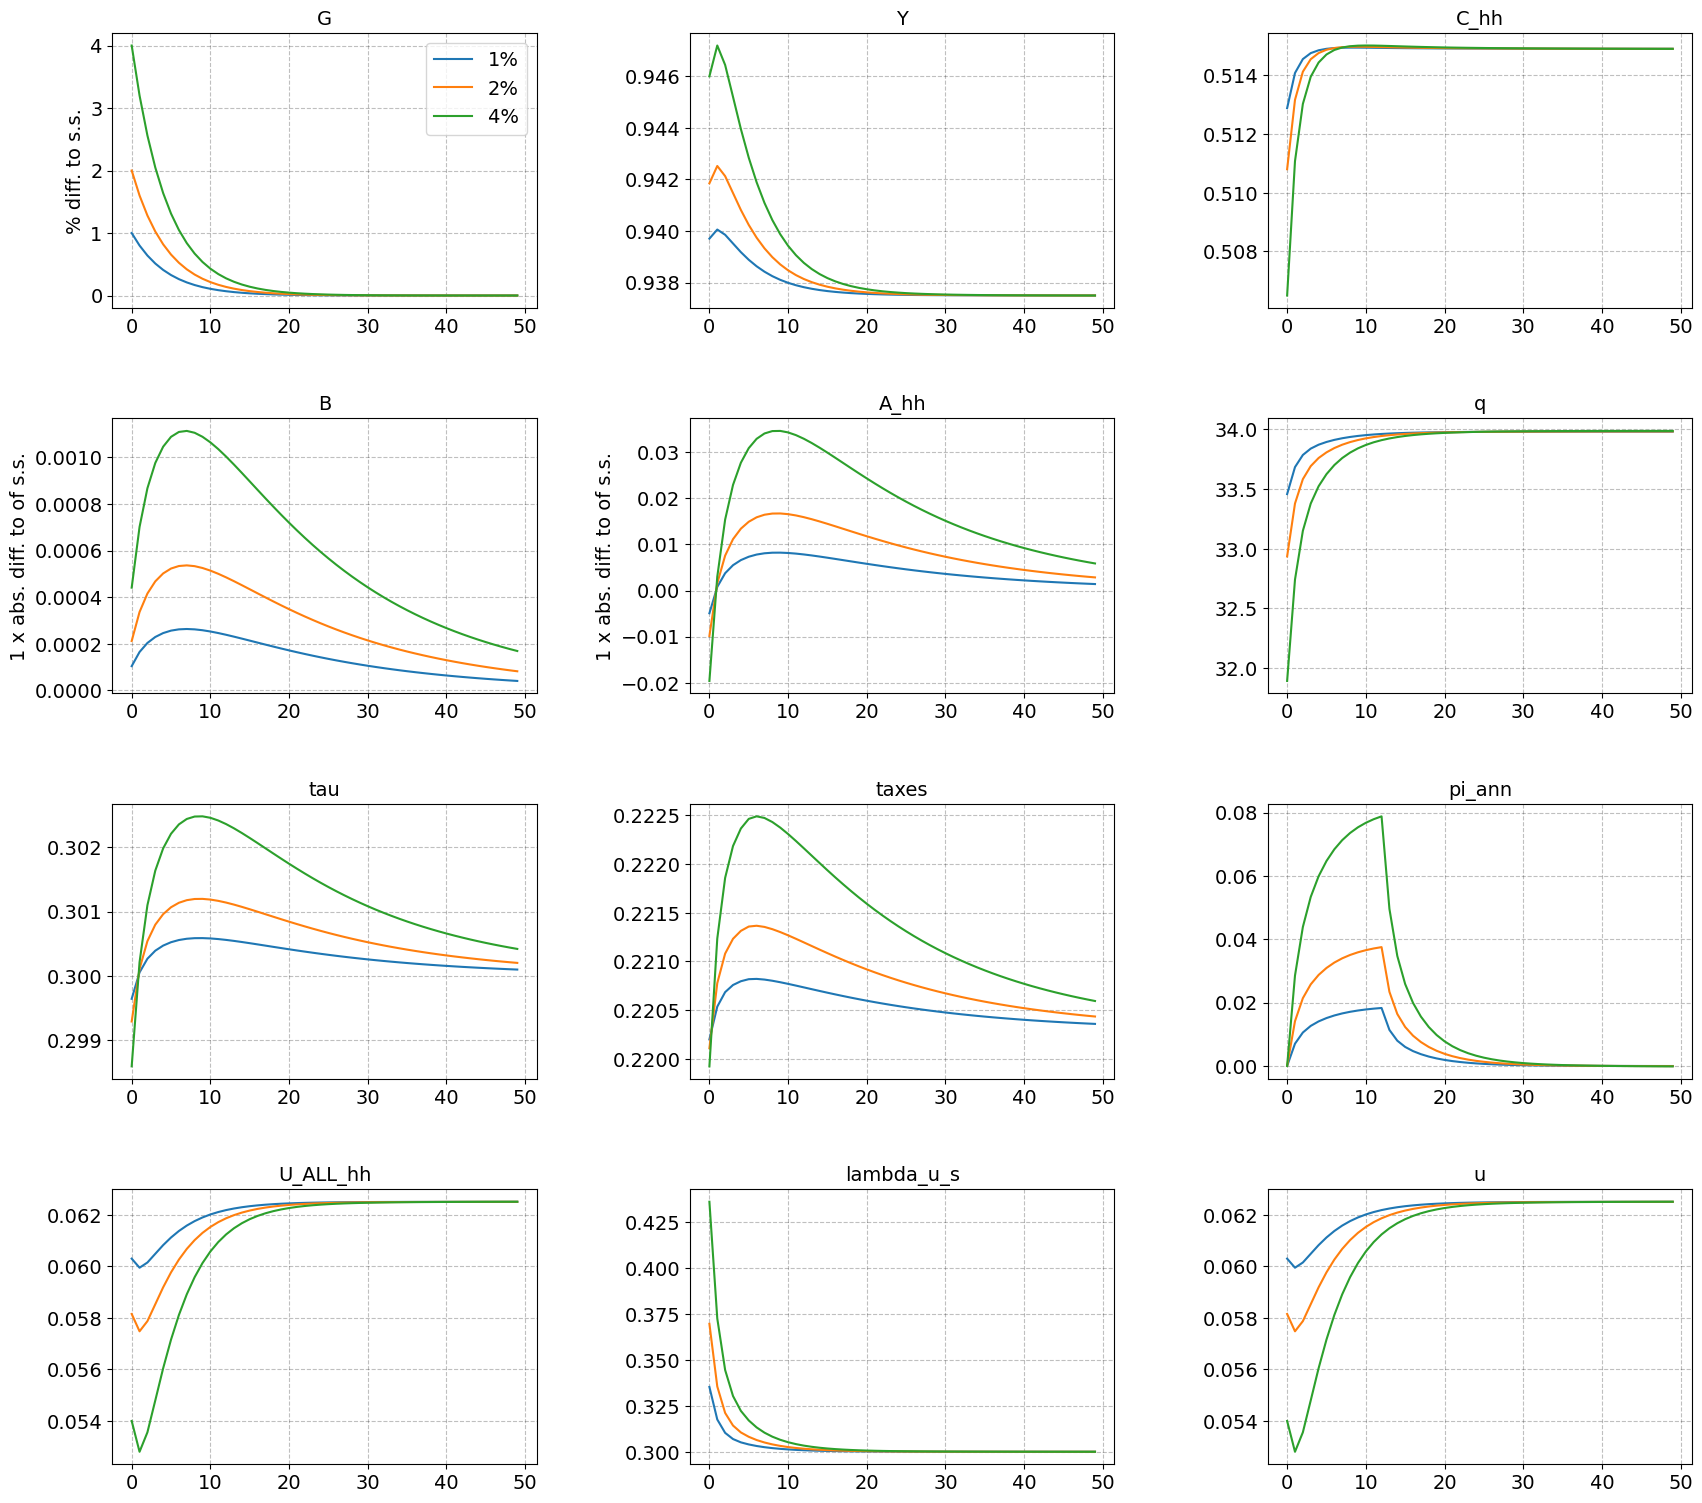

In [11]:
paths = ['G','Y','C_hh','B','A_hh','q','tau','taxes','pi_ann','U_ALL_hh','lambda_u_s','u']
abs_diff = ['B','A_hh']
lvl_value = ['Y','C_hh','q','tau','taxes','pi_ann','u','lambda_u_s','U_ALL_hh']

model.compare_IRFs(models=[model, modelI, modelII],labels=['1%','2%','4%'],varnames=paths,abs_diff=abs_diff,lvl_value=lvl_value,T_max=50,ncols=3,do_targets=False,do_shocks=False,filename='figures/IRFs_G')

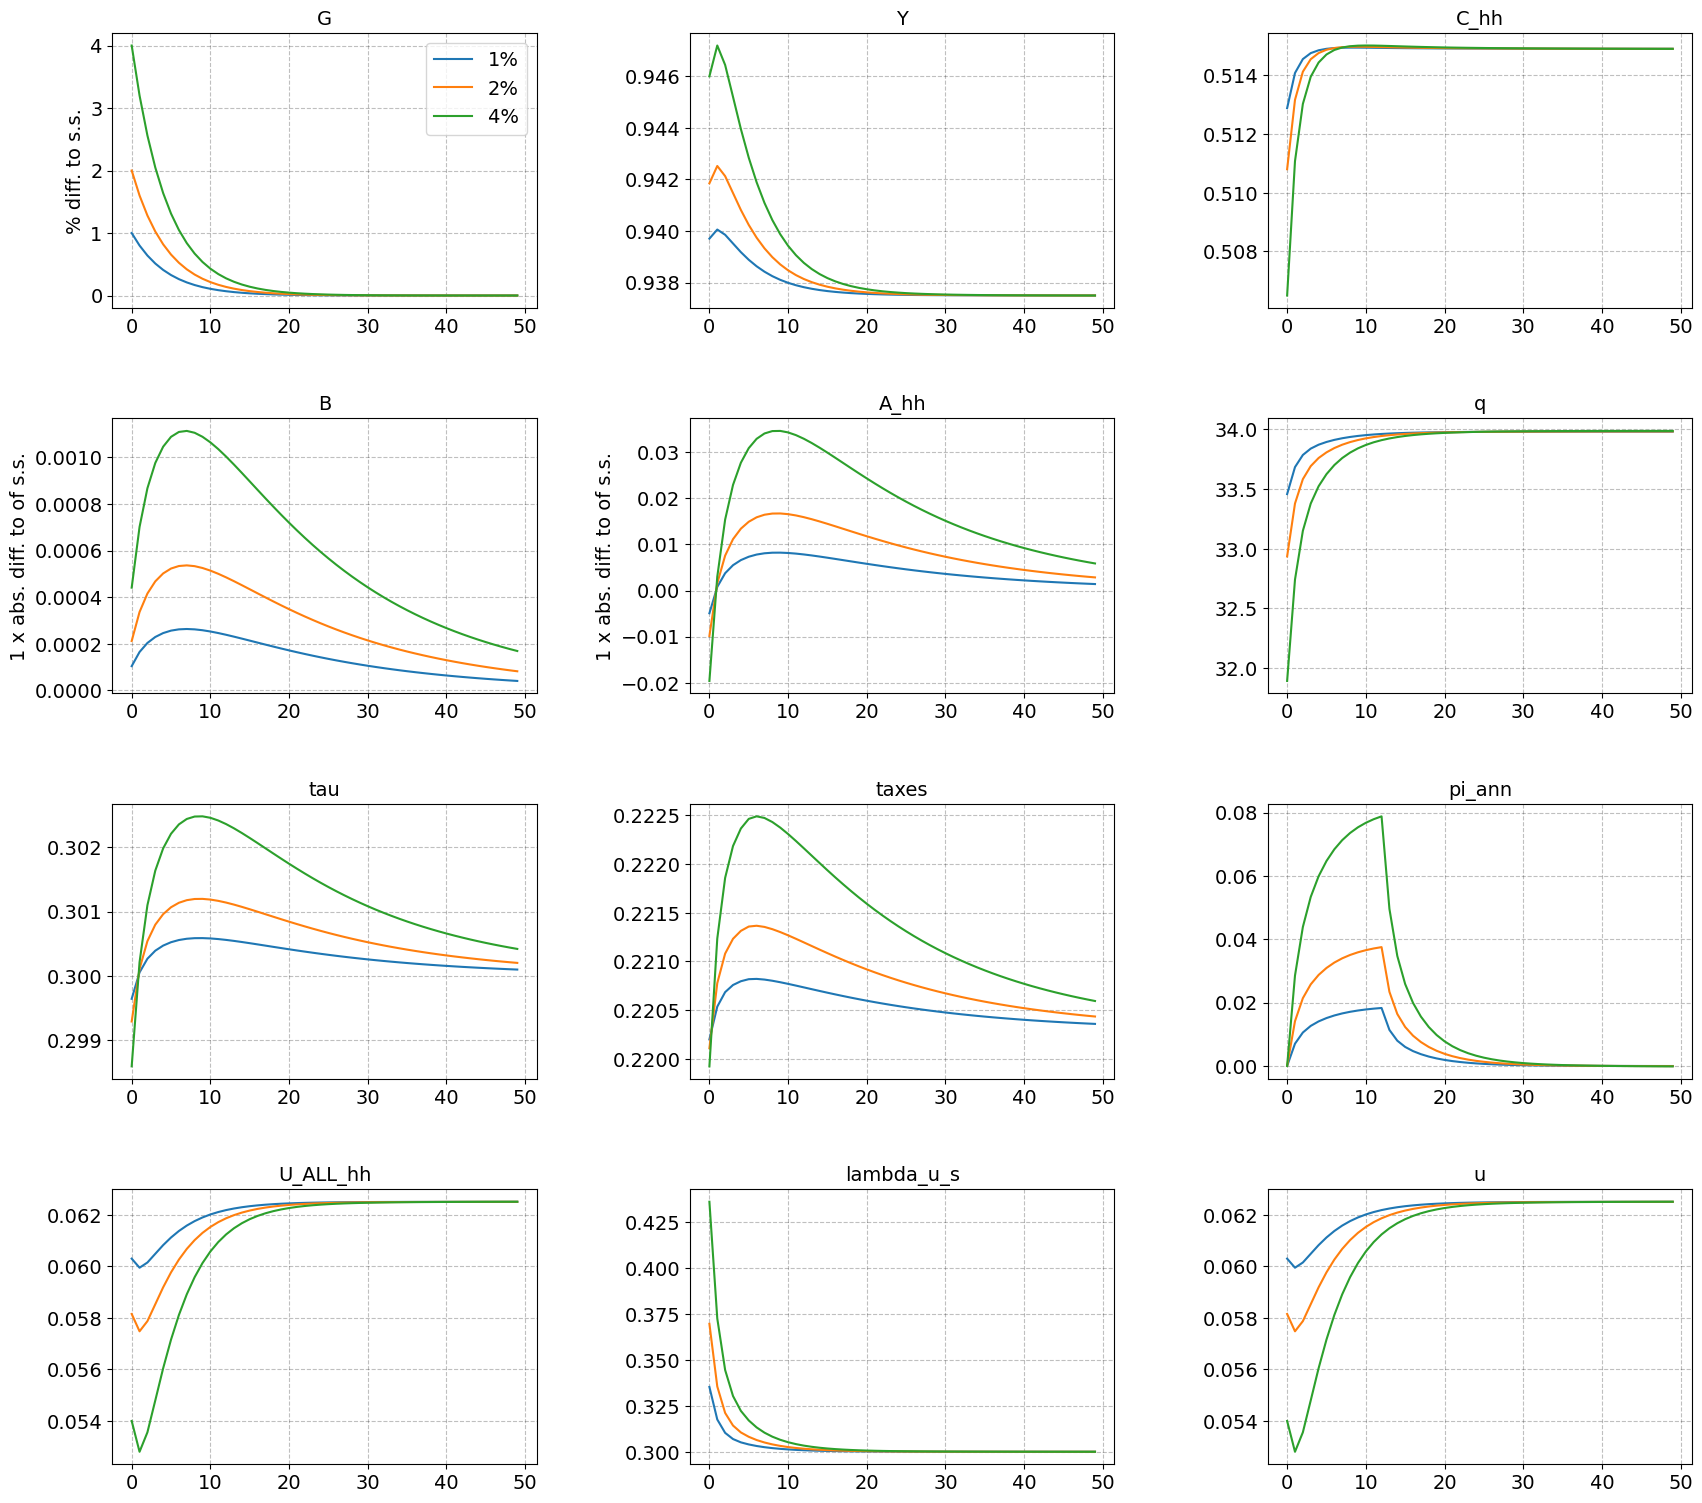

In [12]:
model.compare_IRFs(models=[model, modelI, modelII],labels=['1%','2%','4%'],varnames=paths,abs_diff=abs_diff,lvl_value=lvl_value,T_max=50,ncols=3,do_targets=False,do_shocks=False,filename='figures/IRFs_G')

## Fiscal Multiplier

In [13]:
model.fiscal_multiplier()
model.fiscal_multiplier(type='C_hh')

multiplier = 1.2709
multiplier = -0.2187


-0.21872241481599602

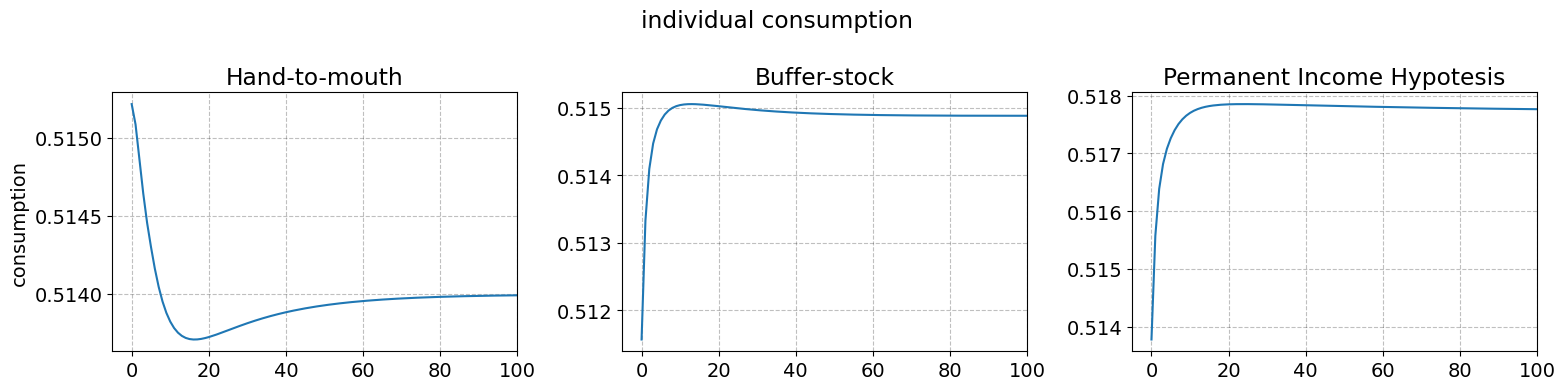

In [14]:
individual_c = np.sum((path.c)*path.D, axis=(-1,-2))/np.sum(path.D, axis=(-1,-2))

# Assume summed_array is your array of shape (480, 3)
fig, axs = plt.subplots(1, 3, figsize=(16, 4), dpi=100)
# Create a new figure

names = ['Hand-to-mouth', 'Buffer-stock', 'Permanent Income Hypotesis']

# Loop over the columns of the array
for i, name in enumerate(names):
    # Create a subplot for the i-th column
    plt.subplot(1, 3, i+1)
    # Plot the i-th column with the corresponding name as label
    plt.plot(individual_c[:, i])
    # Add a legend
    axs[i].set_title(name)
    plt.xlim([-5, 100])
    if i == 0:
        axs[i].set_ylabel('consumption')

plt.suptitle('individual consumption')
plt.tight_layout()
plt.savefig('figures/individual_consumption.pdf')

In [15]:
# calculating difference in consumption from steady state
individual_ss = np.sum((ss.c)*path.D, axis=(-1,-2))/np.sum(path.D, axis=(-1,-2))
np.sum(individual_c[:,0]-individual_ss[:,0])

-0.00836827633607018

### Different value of $\omega$

In [16]:
modelIII = model.copy()
modelIII.par.omega = 0.25
modelIII.find_transition_path(shocks=['G'],do_print=False,do_end_check=False)

In [17]:
modelIII.fiscal_multiplier()

multiplier = 0.9776


0.9775804926518041

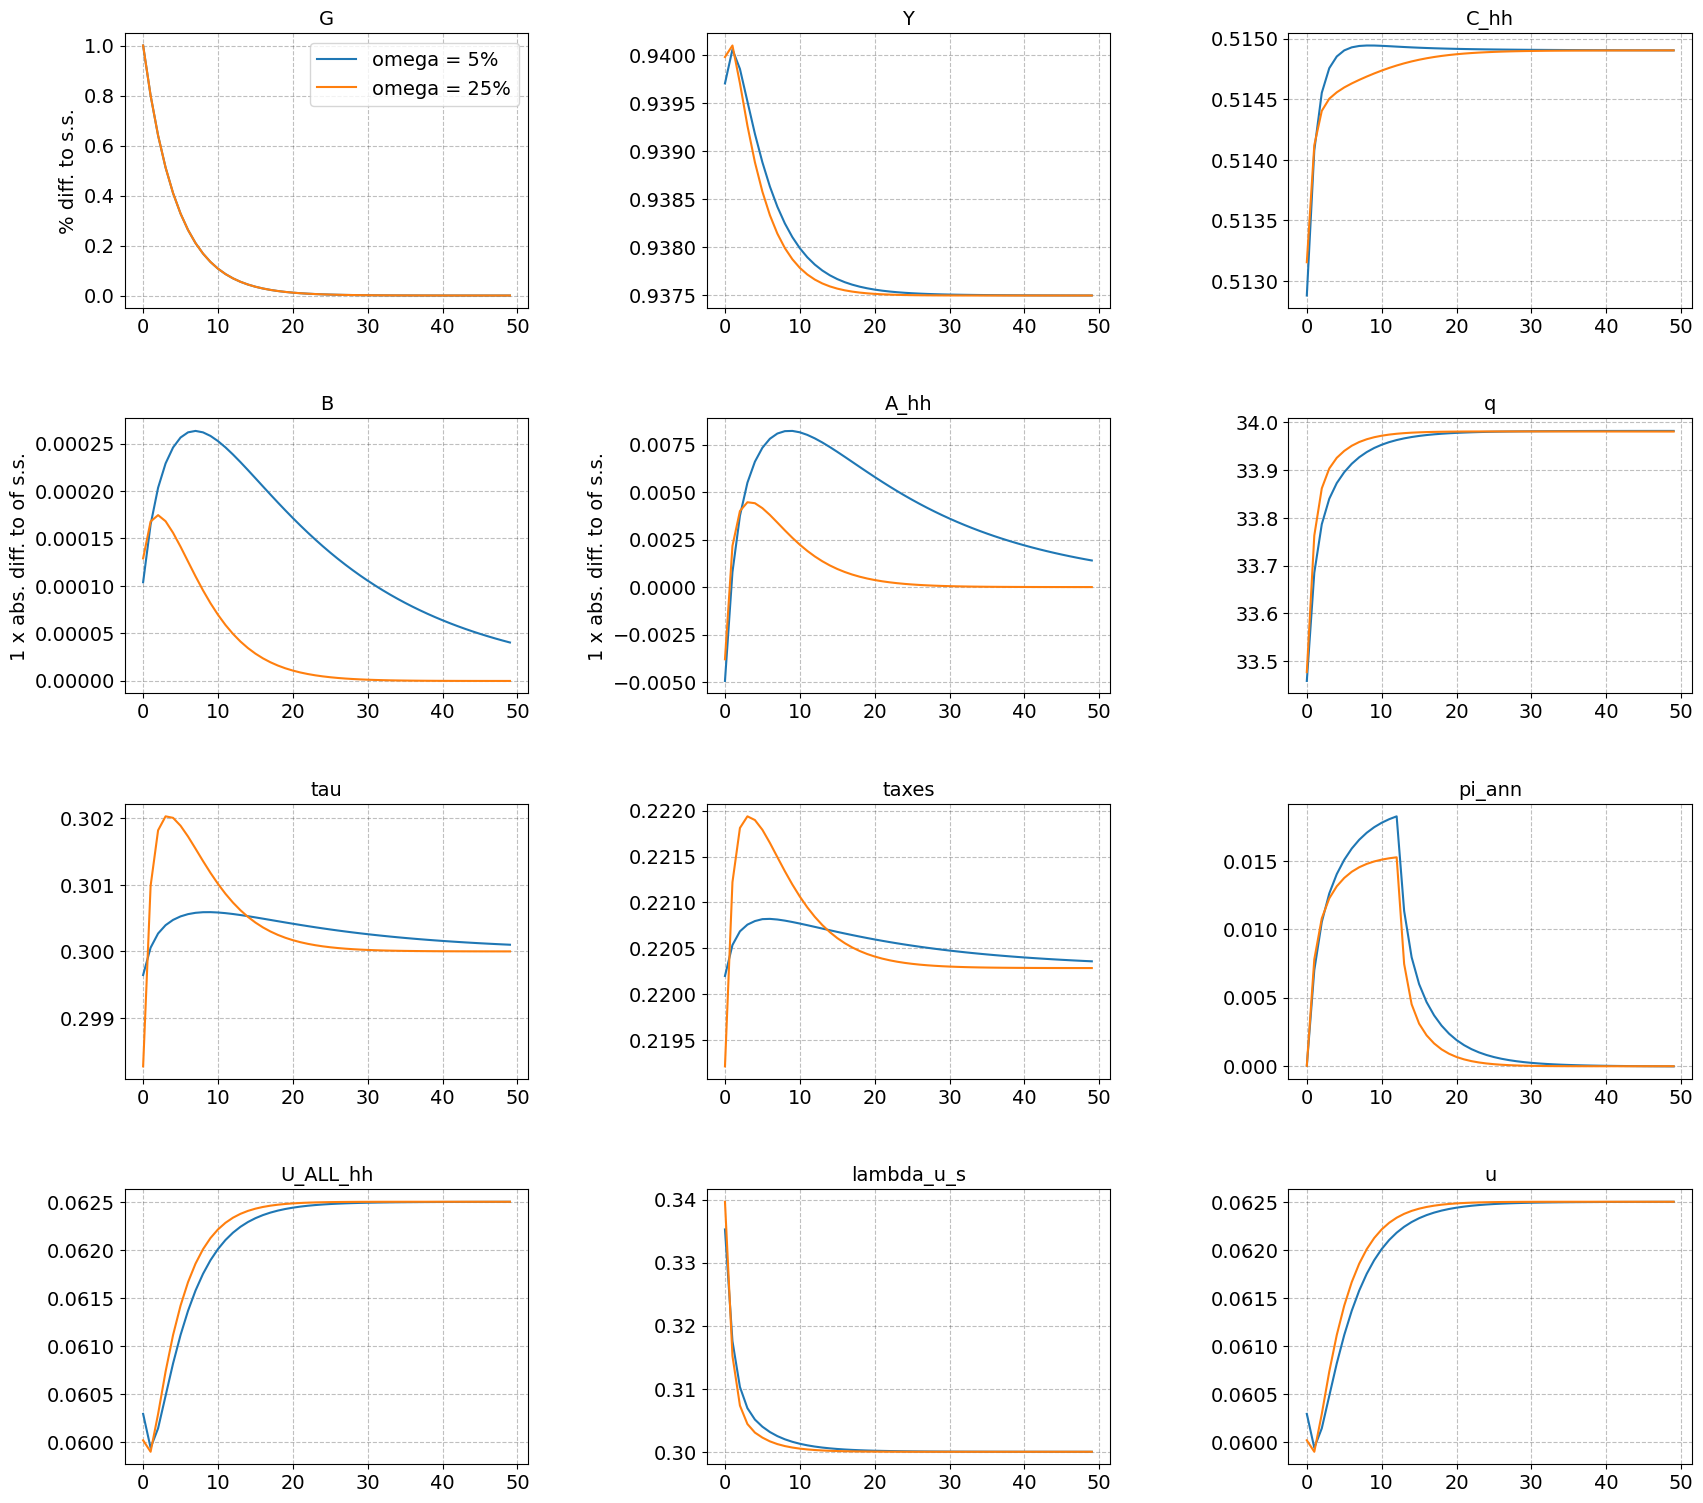

In [18]:
model.compare_IRFs(models=[model, modelIII],labels=['omega = 5%','omega = 25%'],varnames=paths,abs_diff=abs_diff, lvl_value=lvl_value,T_max=50,ncols=3,do_targets=False,do_shocks=False,filename='figures/IRFs_G_omega')

### Increase in share of HTM households

In [19]:
modelIV = model.copy()
modelIV.par.HtM_share = 0.80

modelIV.find_ss(do_print=True)
modelIV.compute_jacs(do_print=False,skip_shocks=True)
modelIV.find_transition_path(shocks=['G'],do_print=False,do_end_check=False)

par.A = 0.3680
par.kappa = 1.8883
ss.w = 0.7500
ss.delta = 0.0200
ss.lambda_u_s = 0.3000
ss.lambda_v = 0.5000
ss.theta = 0.6000
ss.u = 0.0625
ss.S = 0.0625
household problem in ss solved in 3.0 secs [4082 iterations]
household problem in ss simulated in 0.2 secs [1959 iterations]
ss.G = 0.4230
ss.clearing_Y = 0.0000
par.jump_G = 0.0042
steady state found in 3.2 secs


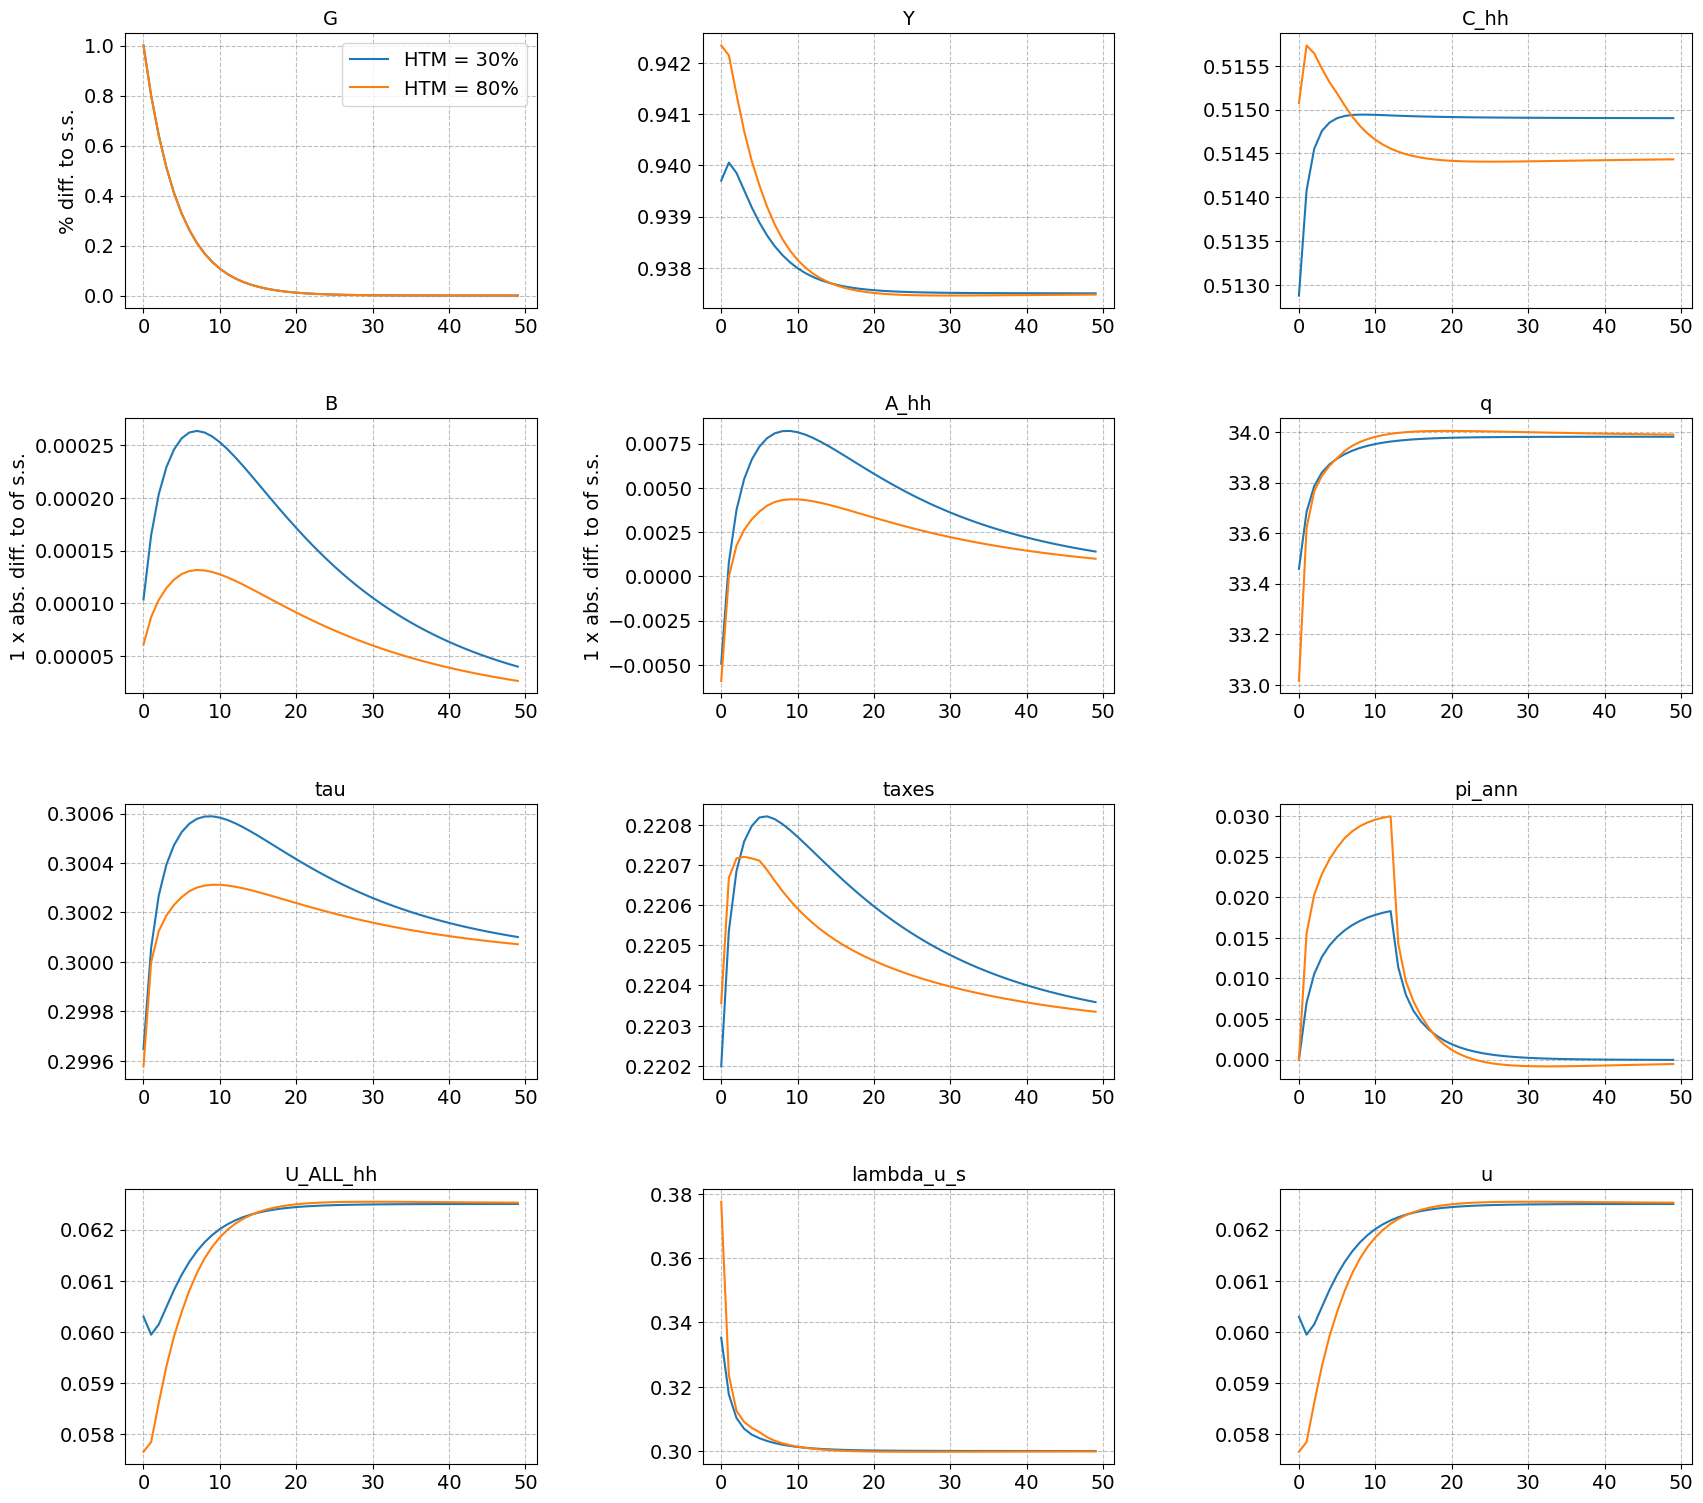

In [20]:
model.compare_IRFs(models=[model, modelIV],labels=['HTM = 30%','HTM = 80%'],varnames=paths,abs_diff=abs_diff,lvl_value=lvl_value,T_max=50,ncols=3,do_targets=False,do_shocks=False,filename='figures/IRFs_G_HTM')

In [21]:
modelIV.fiscal_multiplier()

multiplier = 2.7391


2.739088480296402

### RANKSAM


In [22]:
modelRA = RANKSAMModelClass(name='baseline')
modelRA.ss.u_bar = 6.0

In [23]:
modelRA.find_ss(do_print=True)

par.A = 0.3680
par.kappa = 1.8883
ss.w = 0.7500
ss.delta = 0.0200
ss.lambda_u_s = 0.3000
ss.lambda_v = 0.5000
ss.theta = 0.6000
ss.u = 0.0625
ss.S = 0.0625
household problem in ss solved in 3.0 secs [4082 iterations]
household problem in ss simulated in 0.2 secs [1959 iterations]
ss.G = 0.4226
ss.clearing_Y = 0.0000
par.jump_G = 0.0042
par.beta_RA = 0.9984
steady state found in 3.2 secs


In [26]:
modelRA.compute_jacs(do_print=True,skip_shocks=True)

household Jacobians:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for delta           in 0.6 secs
curly_Y and curly_D calculated for div             in 0.5 secs
curly_Y and curly_D calculated for lambda_u_s      in 0.6 secs
curly_Y and curly_D calculated for r               in 0.5 secs
curly_Y and curly_D calculated for tau             in 0.5 secs
curly_Y and curly_D calculated for transfer        in 0.5 secs
curly_Y and curly_D calculated for u_bar           in 0.5 secs
curly_Y and curly_D calculated for w               in 0.5 secs
curly_E calculated in 0.1 secs
builiding blocks combined in 2.4 secs
household Jacobian computed in 6.8 secs

full Jacobians:
full Jacobian to unknowns computed in 3.1 secs [in evaluate_blocks(): 1.8 secs]


In [27]:
modelRA.find_transition_path(shocks=['G'],do_print=False,do_end_check=False)

In [29]:
modelRA.fiscal_multiplier()

multiplier = 0.7316


0.7315618720121609

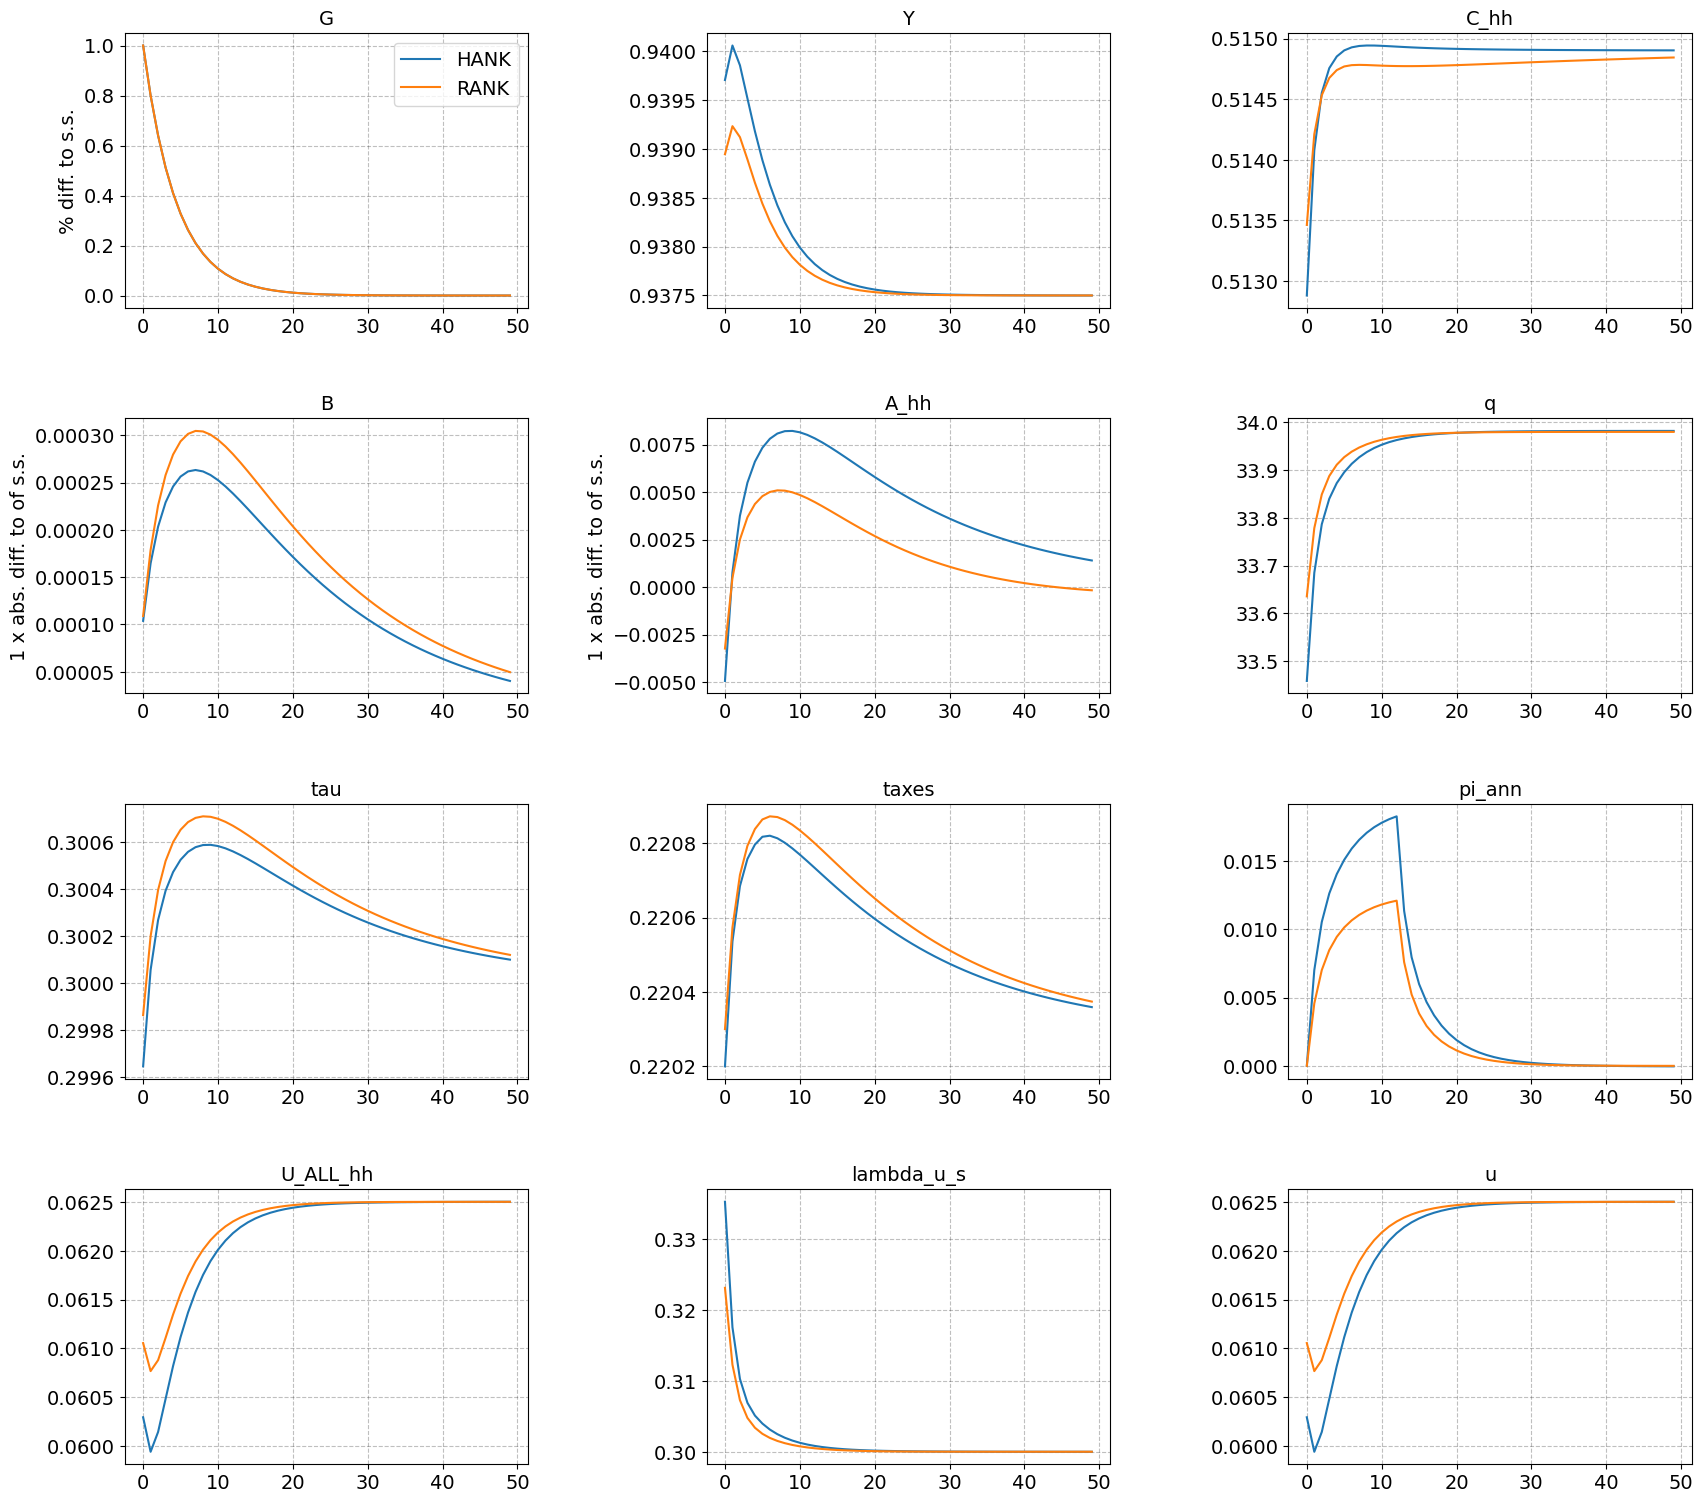

In [28]:
model.compare_IRFs(models=[model, modelRA],labels=['HANK','RANK'],varnames=paths,abs_diff=abs_diff,lvl_value=lvl_value,T_max=50,ncols=3,do_targets=False,do_shocks=False,filename='figures/IRFs_G_HANK_RANK')

## Unemployment insurance duration

In [ ]:
modelV = model.copy()
modelV.ss.u_bar = 7.0

In [ ]:
modelV.find_ss(do_print=True)
modelV.compute_jacs(do_print=False,skip_shocks=True)
modelV.find_transition_path(shocks=['G'],do_print=False,do_end_check=False)

par.A = 0.3680
par.kappa = 1.8883
ss.w = 0.7500
ss.delta = 0.0200
ss.lambda_u_s = 0.3000
ss.lambda_v = 0.5000
ss.theta = 0.6000
ss.u = 0.0625
ss.S = 0.0625
household problem in ss solved in 3.1 secs [4068 iterations]
household problem in ss simulated in 0.3 secs [1929 iterations]
ss.G = 0.4224
ss.clearing_Y = 0.0000
par.jump_G = 0.0042
steady state found in 3.4 secs


In [ ]:
modelV.fiscal_multiplier()

multiplier = 1.3205


1.3204832070854688

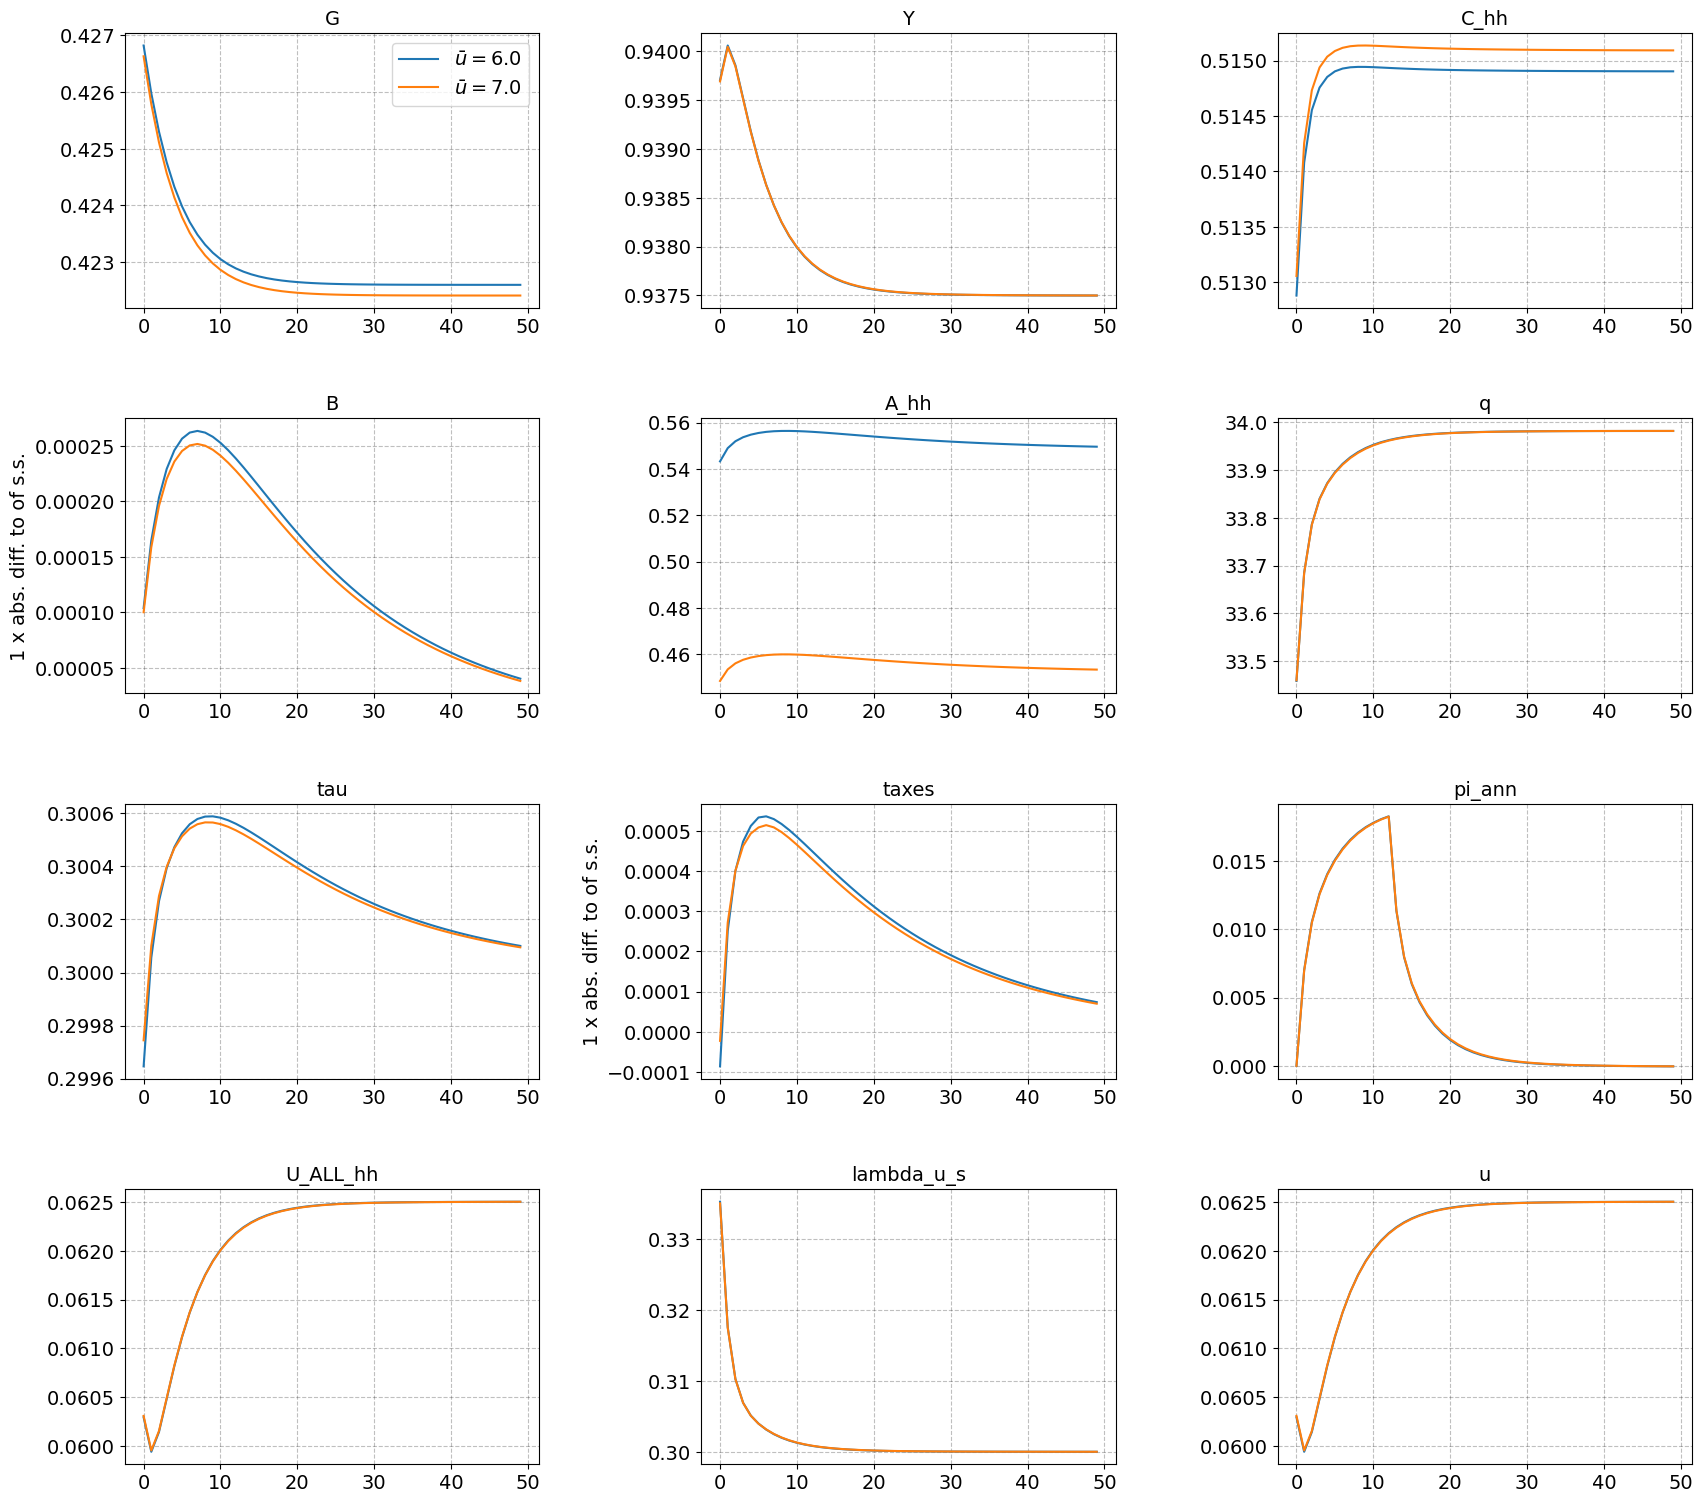

In [ ]:
paths = ['G','Y','C_hh','B','A_hh','q','tau','taxes','pi_ann','U_ALL_hh','lambda_u_s','u']
abs_diff = ['taxes','B']
lvl_value = ['G','Y','C_hh','q','tau','pi_ann','u','lambda_u_s','U_ALL_hh','A_hh']
model.compare_IRFs(models=[model, modelV],labels=['$\\bar{u} = 6.0$','$\\bar{u} = 7.0$'],varnames=paths,abs_diff=abs_diff,lvl_value=lvl_value,T_max=50,ncols=3,do_targets=False,do_shocks=False,filename='figures/IRFs_G_u_bar')

### Shock 1 month in 12 months

In [ ]:
modelVI = model.copy()

du_bar = np.zeros(par.T)
du_bar[:12] = 1.0

shocks = {'du_bar':du_bar} 


In [ ]:
modelVI.find_transition_path(shocks=shocks,do_print=False,do_end_check=False)

In [ ]:
modelVI.fiscal_multiplier()

multiplier = 1.4798


1.4797989628595145

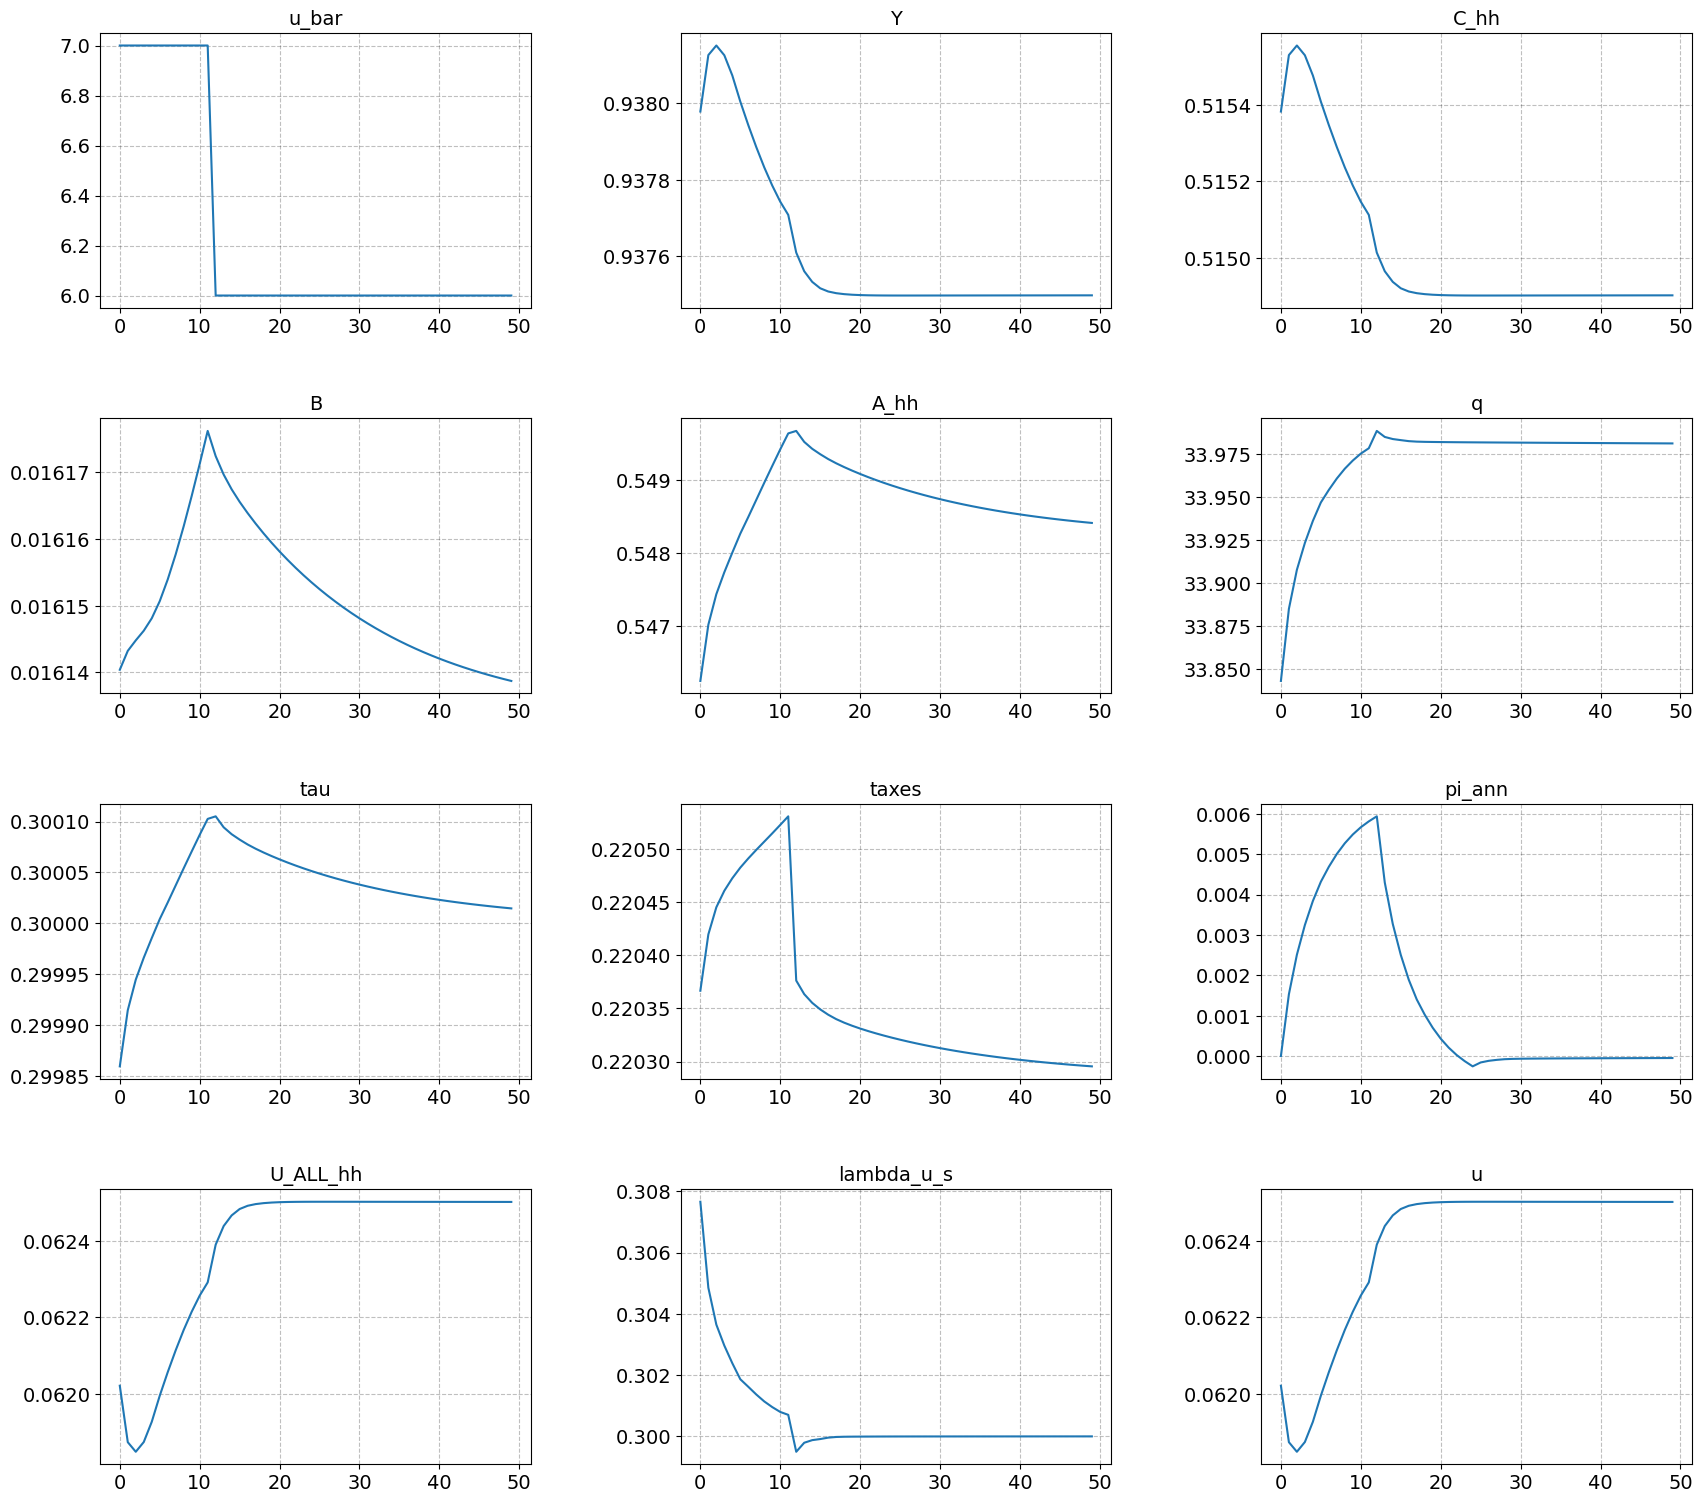

In [ ]:
paths = ['u_bar','Y','C_hh','B','A_hh','q','tau','taxes','pi_ann','U_ALL_hh','lambda_u_s','u']
abs_diff = []
lvl_value = ['u_bar','Y','C_hh','q','B','A_hh','tau','taxes','i_ann','pi_ann','u','lambda_u_s','U_ALL_hh']
modelVI.show_IRFs(varnames=paths,T_max=50,ncols=3, abs_diff=abs_diff,lvl_value=lvl_value,do_targets=False,do_shocks=False,filename='figures/IRFs_du_bar_0-12')

### Annouced shock

In [ ]:
modelVII = model.copy()

du_bar = np.zeros(par.T)
du_bar[12:24] = 1.0

shocks = {'du_bar':du_bar} 
modelVII.find_transition_path(shocks=shocks,do_print=False,do_end_check=False)

In [ ]:
modelVII.fiscal_multiplier()

multiplier = 5.1859


5.185859014108364

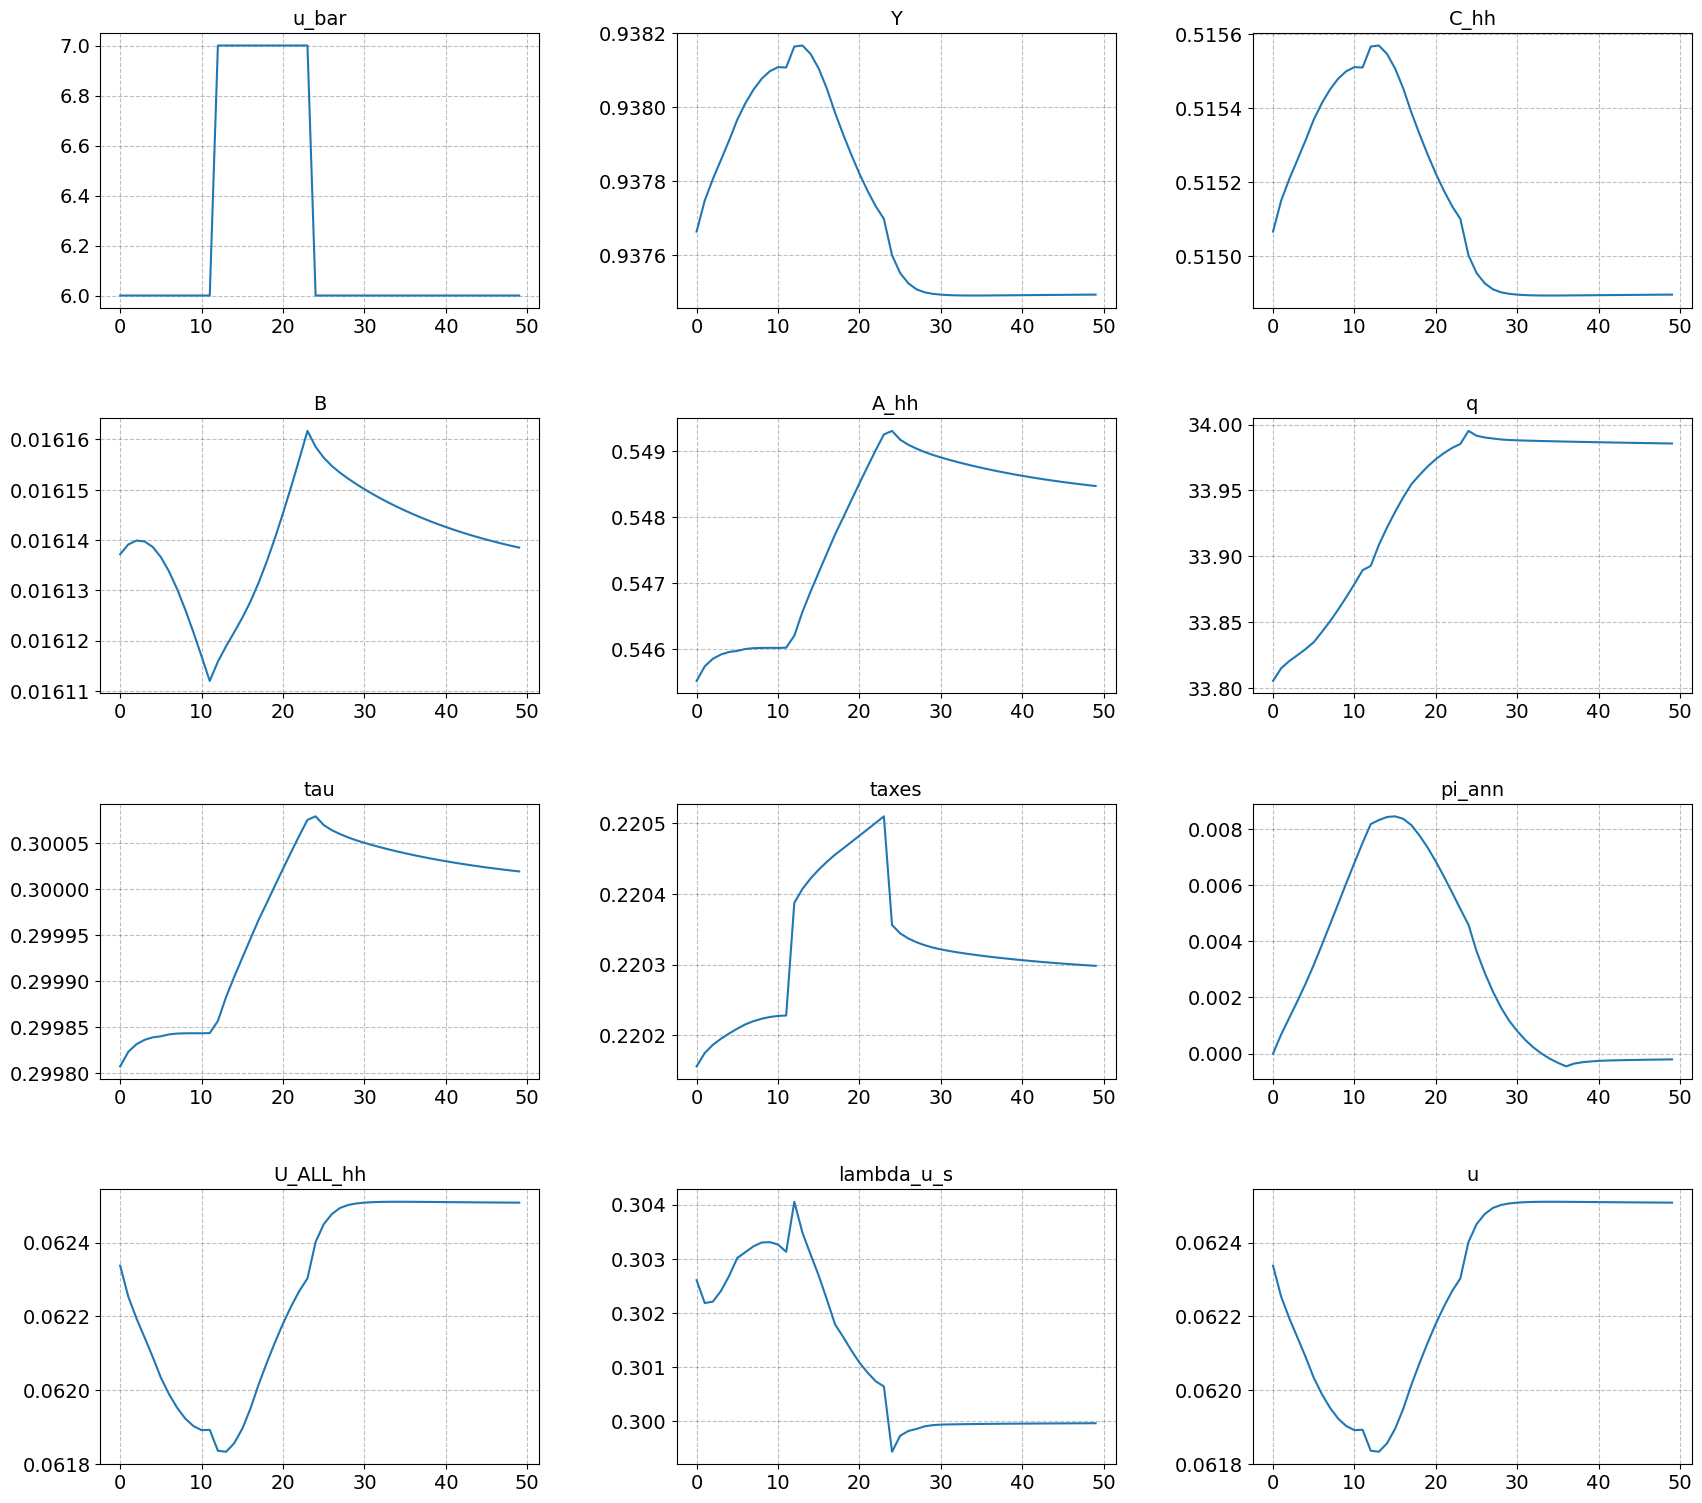

In [ ]:
modelVII.show_IRFs(varnames=paths,T_max=50,ncols=3, abs_diff=abs_diff,lvl_value=lvl_value,do_targets=False,do_shocks=False,filename='figures/IRFs_du_bar_12-24')

### Lying about the shock

In [ ]:
# creating a subset initial values for next transistion back to steady state
ini = SimpleNamespace()

# loop over all parameters in modelVII.path and create ini
for param in dir(modelVII.path):
    if not param.startswith('__'):
        ini.__dict__[param] = modelVII.path.__dict__[param][5:6]
        if ini.__dict__[param].size == 1:
            ini.__dict__[param] = ini.__dict__[param].item()

# change ini to dictionary
ini = vars(ini)

In [ ]:
modelVIIb = model.copy()
modelVIIb.find_transition_path(shocks={},ini=ini,do_print=False,do_end_check=False)

In [ ]:
# loop over all parameters in modelVIIb.path concate with the new 
for param in dir(modelVIIb.path):
    if not param.startswith('__'):
        # concatenate the new path with the old path
        modelVIIb.path.__dict__[param] = np.concatenate((modelVII.path.__dict__[param][:6],modelVIIb.path.__dict__[param][:474]))

In [ ]:
modelVIIb.fiscal_multiplier(print_frac=True)

nominator = 0.00196002
denominator = -0.00052346
multiplier = -3.7444


-3.7443620947474283

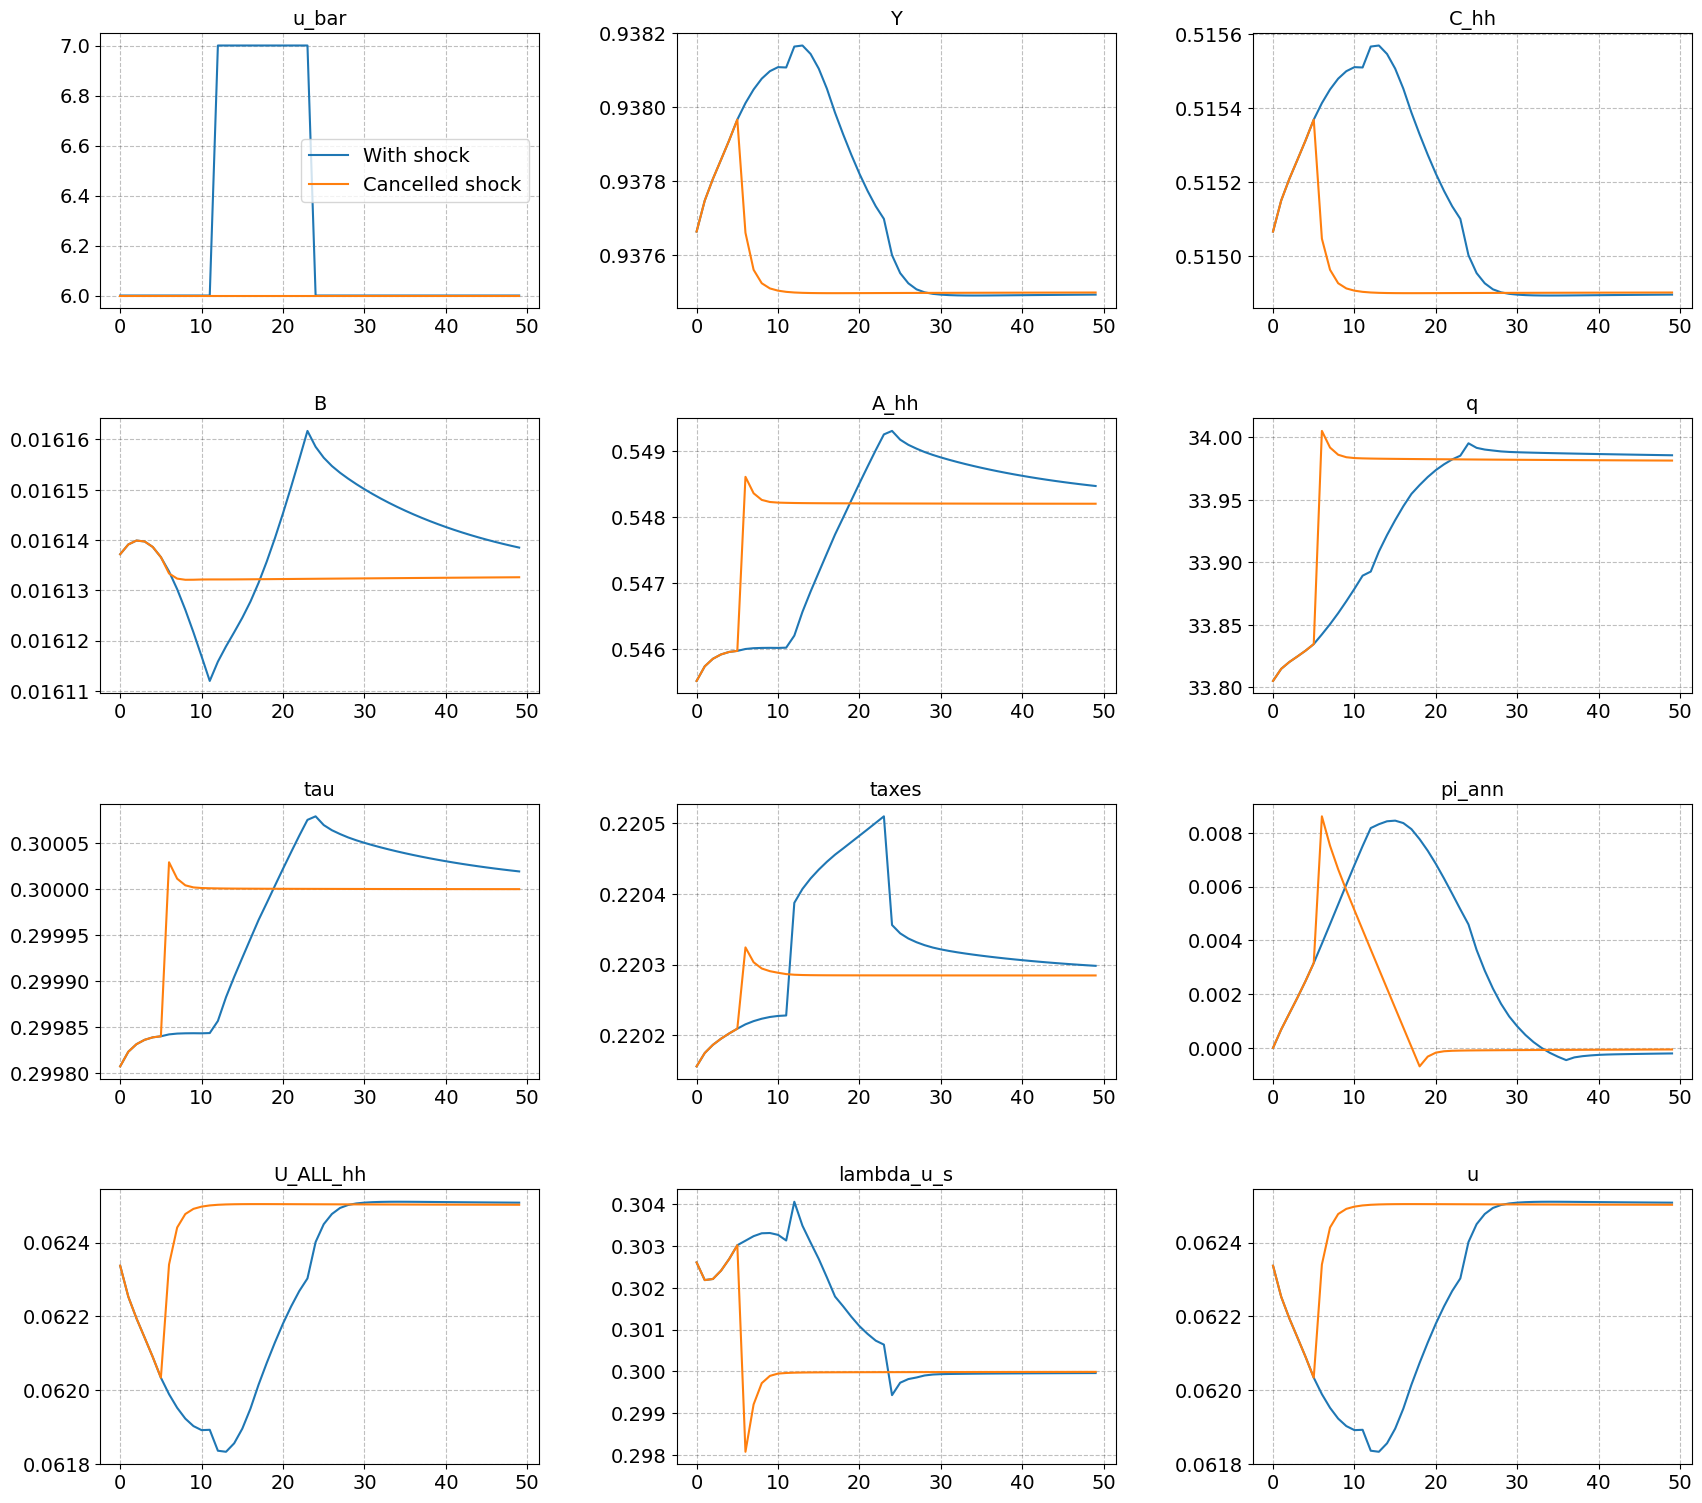

In [ ]:
model.compare_IRFs(models=[modelVII,modelVIIb],labels=['With shock','Cancelled shock'],varnames=paths,abs_diff=abs_diff,lvl_value=lvl_value,T_max=50,ncols=3,do_targets=False,do_shocks=False,filename='figures/IRFs_du_bar_fake_shock')